<a href="https://colab.research.google.com/github/DevanshChoubey/WaterMark_Removal/blob/master/Copy_of_Network_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#credit to pascal voc 2008 data set

@misc{pascal-voc-2008,
	author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
	title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2008 {(VOC2008)} {R}esults",
	howpublished = "http://www.pascal-network.org/challenges/VOC/voc2008/workshop/index.html"}

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir("/content/drive/My Drive/Working_dir")

Using TensorFlow backend.


#### Import the data from the folders created to hold the original images and their corresponding image with a watermark. Standardize and reshape the images to fit into the network. 

In [0]:
raw_dir = 'RAWS/'
wat_dir = 'WATS/'

raw_datagen = ImageDataGenerator(rescale=1./255)

raw_generator = raw_datagen.flow_from_directory(
        raw_dir,  # this is the target directory
        target_size=(250, 250),
        batch_size=5096, shuffle = 0,
        class_mode="categorical")

wat_datagen = ImageDataGenerator(rescale=1./255)

wat_generator = wat_datagen.flow_from_directory(
        wat_dir,  # this is the target directory
        target_size=(250, 250),
        batch_size=5096, shuffle = 0,
        class_mode="categorical")

x_raw,y = raw_generator.next()
x_wat,y = wat_generator.next()

Found 5096 images belonging to 1 classes.
Found 5096 images belonging to 1 classes.


#### Split the data into training and validation sets. 

In [0]:
x_train_raw = x_raw[0:4500]
x_train_wat = x_wat[0:4500]

x_val_raw = x_raw[4500:4900]
x_val_wat = x_wat[4500:4900]

x_train = np.vstack((x_train_raw, x_train_wat))
x_val = np.vstack((x_val_raw, x_val_wat))

In [0]:
y_train = np.repeat([0.], 4500)
y_train = np.append(y_train, np.repeat([1.], 4500))

y_val = np.repeat([0.], 400)
y_val = np.append(y_val, np.repeat([1.], 400))

#### Create the response variables for each data set: images with a watermark have a response of 1, while images without a watermark have a response of 0. 

In [0]:
model = keras.models.Sequential()
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(250, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='elu'))
model.add(layers.Conv2D(100, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((4, 4)))

model.add(layers.Conv2D(75, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(202, activation='elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(40, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])
#model.summary()
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 30, 
          batch_size = 40, verbose = 0)

Train on 9000 samples, validate on 800 samples
Epoch 1/30
9000/9000 [==============================] - 26s 3ms/sample - loss: 0.7138 - acc: 0.5132 - val_loss: 0.6797 - val_acc: 0.5550
Epoch 2/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.6238 - acc: 0.6436 - val_loss: 0.4967 - val_acc: 0.7625
Epoch 3/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.5295 - acc: 0.7329 - val_loss: 0.4411 - val_acc: 0.7987
Epoch 4/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.4701 - acc: 0.7747 - val_loss: 0.4204 - val_acc: 0.7962
Epoch 5/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.4432 - acc: 0.7971 - val_loss: 0.3887 - val_acc: 0.8350
Epoch 6/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.3938 - acc: 0.8183 - val_loss: 0.3904 - val_acc: 0.8300
Epoch 7/30
9000/9000 [==============================] - 19s 2ms/sample - loss: 0.3801 - acc: 0.8312 - val_loss: 0.4616 - val_acc: 0

In [0]:
#write the history to a csv for use in plotting

df = pd.DataFrame(history.history)
df.to_csv('history.csv')

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
!tar -xvf /content/VOCtrainval_14-Jul-2008.tar

In [6]:
import os, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw, ImageOps
import string
import numpy as np
import cv2

Using TensorFlow backend.


In [0]:
#!wget https://github.com/frlim/data2040_final/blob/master/Project3/abel-regular.ttf

prints = list(string.printable)[0:84]

def gen_watermark(im_str, train = 1):
    
    #open all of the images from the VOC2008 dataset as jpegs
    img = Image.open("VOCdevkit/VOC2008/JPEGImages/{}".format(im_str))
    
    #save original image as np array to 'RAWS' directory
    img.save('RAWS/raw_imgs/{}'.format(im_str))
    
    #generate random font size between 30-100
    font_size = np.random.randint(low = 20, high = 100)
    
    #create the watermark font for the image
    font = ImageFont.truetype("abel-regular.ttf", font_size,encoding="unic") 
    
    #generate image to hold the watermark text object
    img_temp = Image.new('L', (350,350))
    
    #create the watermark text, of random length, using random printable characters
    text_str = np.random.choice(prints, np.random.randint(low=5, high = 10))
    text_str = "".join(text_str)
    
    #draw on temporary image with text
    draw_temp = ImageDraw.Draw(img_temp) 
    
    #generate a random integer for the opacity argument (fill)
    opac = np.random.randint(low=90, high=120)
    
    #insert text onto the temporary image
    draw_temp.text((0, 0), text_str,  font=font, fill=opac)
    
    #generate a random integer for rotation:
    rot_int = np.random.randint(low = 0, high = 20)
    
    #rotate the text on the temporary image
    rotated_text = img_temp.rotate(rot_int,  expand=1)
    
    #default color of watermark set to white; change if desired
    col_1 = (255,255,255)
    col_2 = (255,255,255)
    
    #generate a random location for the watermark on the image
    rand_loc = tuple(np.random.randint(low=10,high=100, size = (2,)))
    
    #merge the temporary image with text with the image passed in 
    #third tuple also needs to be random: controls the location of the img
    img.paste(ImageOps.colorize(rotated_text, col_1, col_2), rand_loc,  rotated_text)
    
    #this yeilds a new image with a watermark
    #save this jpeg with a watermark to the WATS directory
    img.save('WATS/wat_imgs/{}'.format(im_str))

In [0]:
rpath = "RAWS"
wpath = "WATS"

if not os.path.exists(rpath):
    os.mkdir(rpath)
    os.mkdir("RAWS/raw_imgs")
else:
    shutil.rmtree(rpath)  
    
if not os.path.exists(wpath):
    os.mkdir(wpath)
    os.mkdir("WATS/wat_imgs")
else:
    shutil.rmtree(wpath)

In [0]:
import os
os.chdir("/content/drive/My Drive/Working_dir")

In [0]:
#generate 
im_list = os.listdir("VOCdevkit/VOC2008/JPEGImages")

#run time is about 5-6 minutes for all 5000 images:
for ind, img in enumerate(im_list):
    
    #add the watermark to the image and save to 'watered' directory
    wat_img = gen_watermark(img)

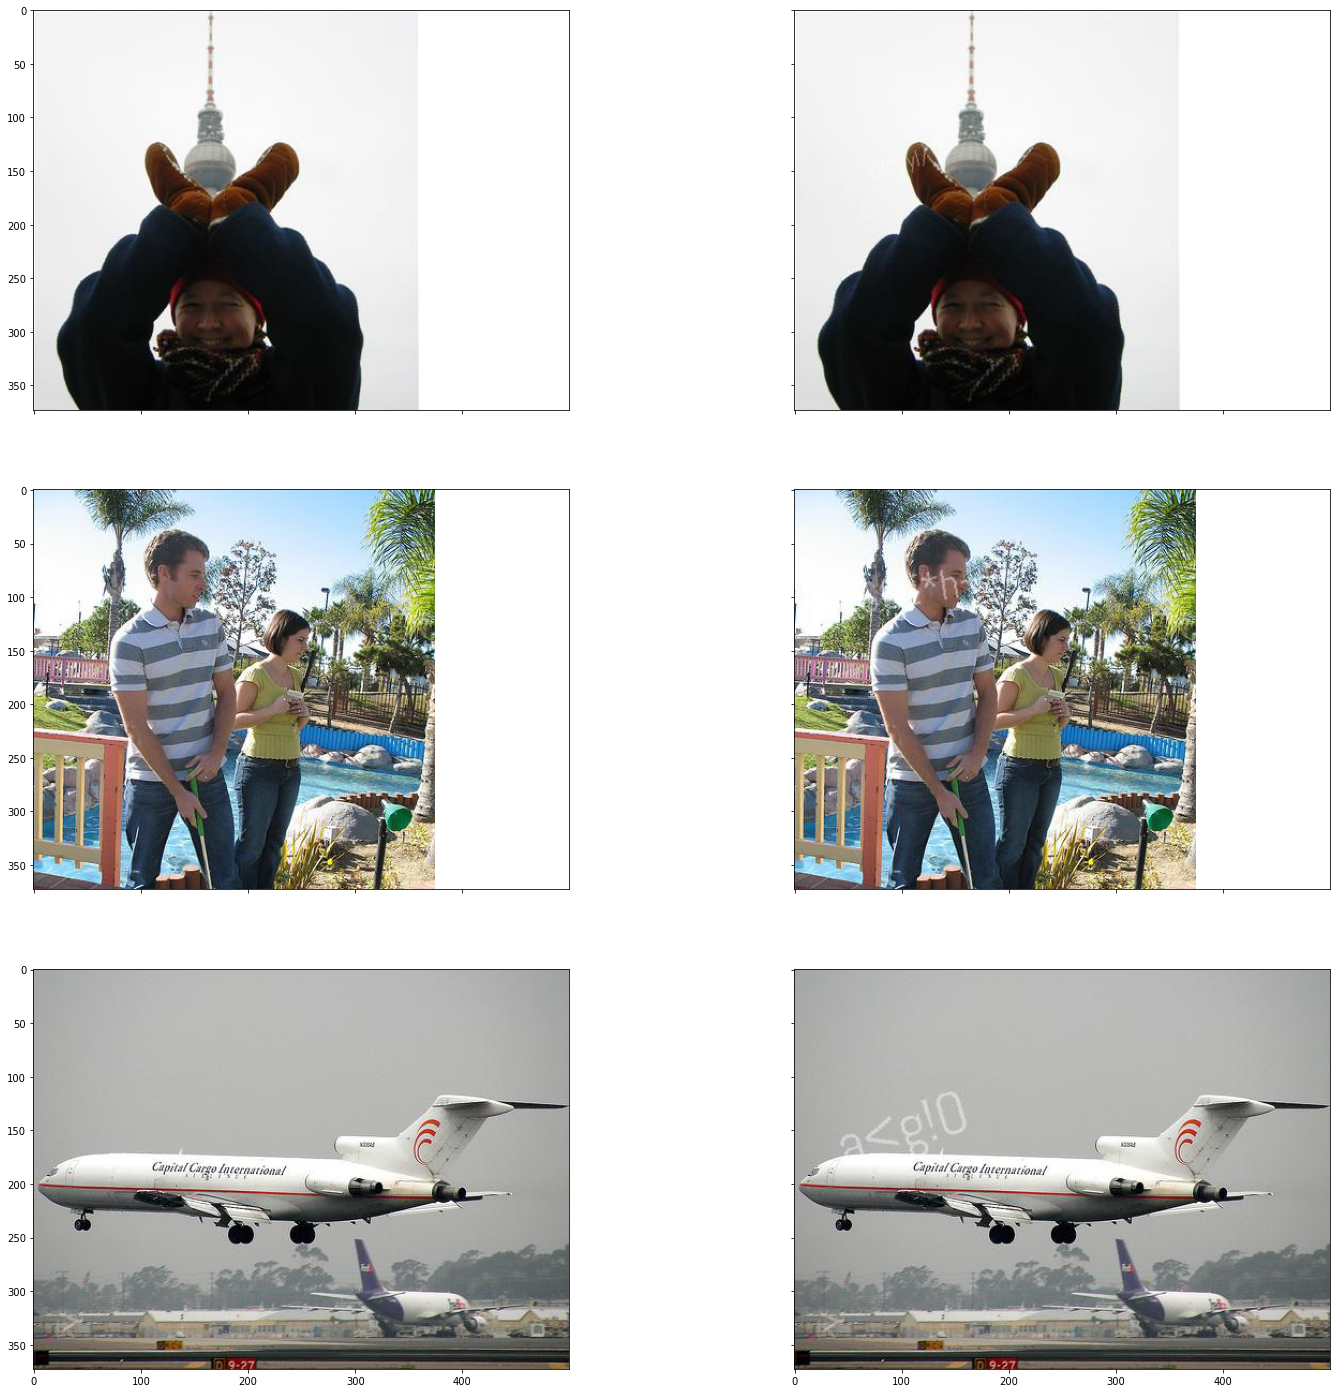

In [21]:
dir_raw = os.listdir("RAWS/raw_imgs")
dir_wats = os.listdir("WATS/wat_imgs")

#example: 
raw_str = "RAWS/raw_imgs/"
wat_str = "WATS/wat_imgs/"

f, axs = plt.subplots(3,2, figsize=(25, 25), sharey=True, sharex = True)
axs = axs.ravel()

img_raw = Image.open(raw_str + dir_raw[4])
img_wat = Image.open(wat_str + dir_wats[4])
axs[0].imshow(img_raw)
axs[1].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[5])
img_wat = Image.open(wat_str + dir_wats[5])
axs[2].imshow(img_raw)
axs[3].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[10])
img_wat = Image.open(wat_str + dir_wats[10])
axs[4].imshow(img_raw)
axs[5].imshow(img_wat)

plt.show()


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r /content/Working_dir "/content/drive/My Drive"